# AC_SDSS-PS1_offsets

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

#outDir = '../data_products/SDSS-PTF-CRTS-PS1_/'
#done_lcs = os.listdir(outDir)
#done_lcs.remove('.DS_Store')

[Prepare datasets](#data)

[Plot offsets](#plot)

### SDSS-PS1 Offsets <a id='offsets'></a>

We used the 10% of the randomly chosen SDSS Standard Stars catalog for which Branimir provided CRTS light curves for Paper1... 

The full stripe82calibStars_v2.6.dat  catalog is 1 mln+ stars.  10% of that is 100 000 , for which Branimir provided CRTS light curves.  Of these, only 48250 have observations over 10 separate days (i.e. 10 day-averaged epochs). These 48250 stars were used to query against PS1 http://panstarrs.stsci.edu MAST database : 
* I made an account on MAST,  suberlak ,  ein2....  http://mastweb.stsci.edu/ps1casjobs/SubmitJob.aspx 

* I uploaded a list of ra,dec  from sdss s82 
     
      address = '../../CRTS_PROJECT/data_products/CRTS_SDSS_combined_stars_catalog.dat'
      crts_stars = Table.read(address, format='ascii')
      crts_stars[['CRTS_name','ra_sdss','dec_sdss']].
                  write('sdss_s82_48250_std_stars_name_radec.txt', 
                  format='ascii', overwrite='True')

* I ingested it as a database

* I set context to `PanStarrs1`

* I execute the following query:  

      select s.ra, s.dec, o.objID, o.raMean, o.decMean,
      o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
       m.gMeanPSFMag, m.gMeanPSFMagErr, m.rMeanPSFMag,m.rMeanPSFMagErr,  
       m.iMeanPSFMag, m.iMeanPSFMagErr, m.zMeanPSFMag, m.zMeanPSFMagErr, 
       m.yMeanPSFMag, m.yMeanPSFMagErr into mydb.PS1_S82_ from MyDB.sdss_s82radec s
      cross apply fGetNearbyObjEq(s.ra,s.dec,2.0/60.0) nb
      inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1
      inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
      
* I save the result as `PS1_S82_suberlak.csv`  / 'PS1_S82_w_err.csv' 

In [6]:
tonry = Table.read('Tonry2012_Table6.txt', 
                   format='ascii', names=['x','y', 'A_0', 'A_1','A_2', '+or-_',
                                          'B_0','B_1','+or-'],)

# Read the SDSS stars for which we have CRTS data : 48250 stars 
sdss_crts = Table.read('/Users/chris/GradResearch/CRTS_PROJECT/data_products/\
CRTS_SDSS_combined_stars_catalog.dat', format='ascii')

# it was prepared with 
# /Users/chris/GradResearch/CRTS_PROJECT/code/B_CRTS_SDSS_matching.ipynb
# by taking the 100 000 CRTS stellar light curves, 
# keeping only those that had more than 10 days of day-averaged data 
# and  cross-matching against the stripe82calibStars_v2.6.dat 
# SDSS Standard Stars catalog 

# select only relevant cols ... 
sdss = sdss_crts[['ra_sdss', 'dec_sdss','raRMS',  'decRMS', 'nEpochs','AR_val', 'u_Nobs',
 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2', 'g_Nobs', 'g_mMed', 'g_mMean',
 'g_mErr', 'g_rms_scatt', 'g_chi2', 'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 
 'r_rms_scatt', 'r_chi2', 'i_Nobs', 'i_mMed', 'i_mMean',  'i_mErr', 'i_rms_scatt', 
 'i_chi2', 'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']]


# Read the CASjobs result of querying PS1 against the 48250 SDSS stars 
# 
ps1_stars = Table.read('PS1_S82_w_err.csv', format='ascii')
ps1_stars.rename_column('ra', 'raSDSS')
ps1_stars.rename_column('dec', 'decSDSS')


# Since the PS1 catalog is the result of querying with these SDSS ra,dec ,  
# each PS1 here definitely has a 'perfect' SDSS match (i.e. each PS1 object 
# here is a best match) 

## match PS1 catalog  to SDSS stars 
ps1_coords = SkyCoord(ra=ps1_stars['raSDSS'].data.data*u.degree, 
                     dec= ps1_stars['decSDSS'].data.data*u.degree)
sdss_coords = SkyCoord(ra=sdss['ra_sdss'].data.data*u.degree, 
                        dec=sdss['dec_sdss'].data.data*u.degree)

# match SDSS to PS1 , because SDSS here has 48250 vs 53000 rows ... 
# I think CASJobs returned more than one match per SDSS object .... 
idx, sep2d, dist3d = sdss_coords.match_to_catalog_sky(ps1_coords) 

sdss['d2d_arcsec']=sep2d.value*3600

sdss_ps1 = hstack([sdss, ps1_stars[idx] ])

print('Done')
sdss_ps1.write('sdss_ps1_stripe82calibStars.txt', format='ascii')

Done


Find out which of the standard stars catalog these were... 

In [5]:
address = '../../CRTS_PROJECT/catalogs_SDSS/stripe82calibStars_v2.6.dat'
s82 = Table.read(address, format='ascii', 
             names = ['col1', 'RA','Dec','RArms','Decrms','Ntot','Ar', 
            'uNobs','umed', 'ummu', 'umsig', 'umrms', 'umchi2',
            'gNobs','gmed', 'gmmu', 'gmsig', 'gmrms', 'gmchi2',
            'rNobs','rmed', 'rmmu', 'rmsig', 'rmrms', 'rmchi2',
            'iNobs','imed', 'immu', 'imsig', 'imrms', 'imchi2',
            'zNobs','zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2']
            )

# make a new column 
s82['starID'] = np.arange(len(s82))

#Store the starID,  RA, Dec  for future use 
s82[['starID', 'RA', 'Dec']].write('stripe82calibStars_v2.6_starID.txt' , format='ascii')

Crossmatch

In [11]:
s82 = Table.read('stripe82calibStars_v2.6_starID.txt', format='ascii')

s82_coords = SkyCoord(ra=s82['RA'].data*u.degree, 
                     dec= s82['Dec'].data*u.degree)
sdss_ps1_coords = SkyCoord(ra=sdss_ps1['ra_sdss'].data*u.degree, 
                           dec=sdss_ps1['dec_sdss'].data*u.degree)

# match SDSS-PS1 to S82 , because SDSS-PS1 has 48250 rows, and S82 catalog 1 mln + 
idx, sep2d, dist3d = sdss_ps1_coords.match_to_catalog_sky(s82_coords) 

sdss_ps1['d2d_s82']=sep2d.value*3600

sdss_ps1 = hstack([sdss_ps1, s82[['starID', 'RA', 'Dec']][idx] ])

print('Done')
sdss_ps1.write('sdss_ps1_stripe82calibStars.txt', format='ascii')

Done


In [27]:
sdss_ps1[['ra_sdss', 'RA', 'dec_sdss', 'Dec', 'starID']]

ra_sdss,RA,dec_sdss,Dec,starID
float64,float64,float64,float64,int64
0.040063,0.040063,0.55537,0.55537,682664
0.054511,0.054511,-1.1499029,-1.1499029,683559
0.073721,0.073721,0.404988,0.404988,685679
0.078358,0.078358,0.235094,0.235094,685700
0.093134,0.093134,0.751608,0.751608,684502
0.100371,0.100371,1.1440089,1.1440089,685310
0.100521,0.100521,0.309938,0.309938,685711
0.110501,0.110501,1.2332392,1.2332392,685311
0.115436,0.115436,0.686838,0.686838,684523


In [40]:
np.sum(sdss_ps1['ra_sdss'] -sdss_ps1['RA'])

0.0

In [41]:
np.sum(sdss_ps1['dec_sdss'] -sdss_ps1['Dec'])

0.0

Thus they are indeed numerically identical. All went well. Now we know exactly which rows from the SDSS  `stripe82calibStars_v2.6` catalog   have CRTS data with 10days+ of obs, and are used here for PTF,  CRTS,  and PS1  offsets.  

### Correcting SDSS stars for extinction... 

* most helpful website that shows the simple relationship between magnitude measured and how dimming by extinction is expressed by Av http://astro.wku.edu/labs/m100/mags.html
* more photometry http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/L04/index.html
* very nice illustration of seeing  http://spiff.rit.edu/classes/phys445/lectures/atmos/atmos.html 
* good notes (detailed) on extinction http://www.astro.ncu.edu.tw/~wchen/Courses/ISM/11.Extinction.pdf



In [4]:
# Ar: the Schlegel, Finkbeiner & Davis (1998) ISM extinction value in 
###     the r band; extinction in other bands can be computed as [Rv=3.1]: 
###     Am = Cm*Ar, with Cm=(1.873, 1.377, 0.758, 0.537) for m=(ugiz) 

Correcting PS1 stars for extinction : the problem here is that the extinction would be different in PS1 and in SDSS passbands : indeed ,  Ar(p1) is not the same as Ar(SDSS)...

Let's try using dustmaps http://argonaut.skymaps.info/usage, and see whether we get a reasonable result ... 

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarWebQuery
from dustmaps.config import config
config['data_dir'] = '/Users/chris/GradResearch/dustmaps'

In [4]:
# download the Schlegel-Finkbeiner-Davis1998  
# http://adsabs.harvard.edu/abs/1998ApJ...500..525S
# Dust Maps 
# Run that only once ! 
import dustmaps.sfd
dustmaps.sfd.fetch()

# this should be the same as what is provided in the Ar column
# of SDSS Standard Stars .... 

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [5]:
import dustmaps.bayestar
dustmaps.bayestar.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [6]:
from dustmaps.sfd import SFDQuery
sfd = SFDQuery()
ebv_sfd = sfd(coords)
# try on an example SDSS S82 star 
coords  = SkyCoord(sdss_ps1[0]['ra_sdss']*units.deg,
                   sdss_ps1[0]['dec_sdss']*units.deg,
                   frame='icrs')
ebv_sfd = sfd(coords)

# I use table6 from Schlafly,Finkbeiner2011 
# http://iopscience.iop.org/article/10.1088/0004-637X/737/2/103/meta 
# to convert to Ar ...

Ar = 2.285 * ebv_sfd
print(Ar)
print(sdss_ps1[0]['ra_sdss','dec_sdss', 'AR_val'])
table6 = Table.read('SchlaflyFinkbeiner2011_Table6.txt', format='ascii',
                   names=['band', 'l', '2.1','3.1', '4.1', '5.1'])





0.0562585052289
ra_sdss  dec_sdss AR_val
-------- -------- ------
0.040063  0.55537  0.068


Why are they not the same ?   Well, try using that anyway.... 

Test whether the Schlegel, Finkbeiner & Davis (1998) ISM extinction value in the r band
stored in S82 standards file is the same as that from dustmaps SFD ... 
  

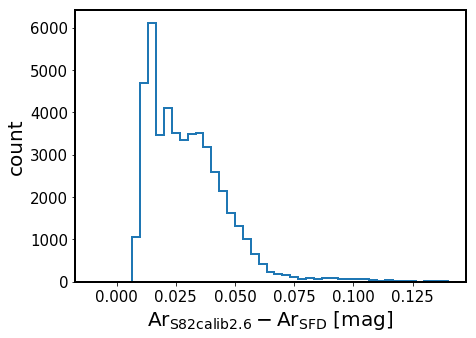

In [20]:
import matplotlib.pyplot as plt 
coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                   sdss_ps1['dec_sdss']*units.deg,
                   frame='icrs')
ebv_sfd = sfd(coords)


coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                   sdss_ps1['dec_sdss']*units.deg,
                   frame='icrs')
ebv_sfd = sfd(coords)


Ar = 2.285 * ebv_sfd

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.hist(sdss_ps1['AR_val'] - Ar, histtype = 'step', lw = 2 , bins=45,
        range=(-0.01,0.14))
ax.set_xlabel(r'$\mathrm{Ar}_{\mathrm{S82calib2.6}} - \mathrm{Ar}_{\mathrm{SFD}}$'+' [mag]')
ax.set_ylabel('count')
plt.savefig('Ar_S82_vs_dustmaps_SFD.png', bbox_inches='tight')

Why is there a nonzero offset??? I would have thought that some random offset would center on 0, but here all stars in S82 catalog have bigger extinction value in r-band than what's stored in the SFD map available via dustmaps. ... Weird! 

Compare to Bayestar maps ...  I choose the distance as 4 kpc as this corresponds to the majority of SDSS Standard Stars according to SF2011...



In [7]:
from dustmaps.bayestar import BayestarQuery
coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                   sdss_ps1['dec_sdss']*units.deg, 
                   distance=4*units.kpc,
                   frame='icrs')
bayestar = BayestarQuery(max_samples=1)
ebv = bayestar(coords, mode='median')
Ar =  2.285  * ebv


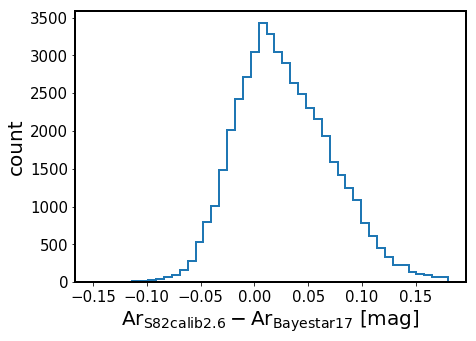

In [18]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.hist(sdss_ps1['AR_val'] - Ar, histtype = 'step', lw = 2 , bins=45,
        range=(-0.15,0.18))
ax.set_xlabel(r'$\mathrm{Ar}_{\mathrm{S82calib2.6}} - \mathrm{Ar}_{\mathrm{Bayestar17}}$'+' [mag]')
ax.set_ylabel('count')
plt.savefig('Ar_S82_vs_dustmaps_Bayestar17.png', bbox_inches='tight')




Be **consistent** : 
    
   1) Use SFD dustmaps EBV for both SDSS and PS1 because they are not the same 
    
   2) Use Bayestar17 EBV for both SDSS, PS1, assuming the distance of 4 kpc (which is the distance of SDSS standards studied in SchlaflyFinkbeiner2011 )

In [128]:
a = 'r'
m = 5*a
originfilters = 'grizy'

sdssfilters = len(originfilters) * 'r'
sdssfilters

'rrrrr'

### PS1 --> SDSS offsets <a id='plot'></a>

Load the SDSS-PS1 dataset crossmatched above .... 

In [12]:
sdss_ps1  = Table.read('sdss_ps1_stripe82calibStars.txt', format='ascii')

In [14]:
#sdss_ps1[:10]

In [22]:
# Try to combine all in one function ...
%matplotlib inline 
def photometric_offset_sdss_ps1(data, sdsscolors = 'gr', 
                                targetbands = 'grizz', originbands = 'grizy',
                                cutoffmag = 19 , xlims = [-0.5,2.5],
                                correct_extinction = True, 
                                ebv_sfd = None,
                                extinction = 'SFD', nrows=3, ncols=2,
                                storeStarID = False
                               ):
    '''
    Find photometric offsets between SDSS and PS1, 
    or another survey. 
    
    data :  a table containing ugriz SDSS photometry, cross-matched to 
            the target survey, eg. SDSS-PS1
            
    sdsscolors : SDSS colors used to spread the stellar locus.  It can be 
           "gr" or "gi" (this mainly affects the x-axis limits)
           
    targetbands : SDSS bands to emulate. It can be "r" if all photometry 
           from target survey should be compared to SDSS(r), eg. 
           PS1(gri) --> SDSS(rrr),  or "grizz"  if each source band
           should be compared to an equivalent SDSS band, eg.
           PS1(grizy) --> SDSS(grizz)  (as in Tonry2012 for PS1).
           
    originbands : bands present in the origin survey. Eg, for PS1 they're 
           'grizy'
    
    cutoffmag : magnitude cutoff to ignore very faint stars according
          to SDSS target magnitude (eg. if yaxis is "grizz" then we filter
          by "grizz < cutoffmag" separately for each panel)
          
    xlims : limits on the x-axis in magnitudes (depends on the 
          SDSS color chosen for the x-axis). By default, [-0.5,2.5]
          
    correct_extinction : shall we correct for  interstellar extinction before 
          finding offsets ? If "True" , then "ebv_sfd"  needs to be provided,
          which is expected to be an array of the same length as the input SDSS 
          table ("data"). E(B-V) is selective extinction at V, or "reddening" : 
          E(B-V) = (B-V)_obs - (B-V)_true , with B,V being magnitudes in B,V. 
          Then the "total extinction" A(V) in a given filter, eg. V, is linked to 
          E(B-V) via the "extinction law"  : 
          A(V) = R(V) * E(B-V) , where R(V) is most commonly taken to be 3.1 . 
          The total extinction is expressed in magnitudes, that have to be
          subtracted from the observed magnitudes - object becomes brighter : 
          m_(V,corr) = m_(V,obs) - A(V), 
          so that the corrected distance modulus : 
          5 * log_10(d_(V,corr)) = m_(V,obs) - A(V) - M_V + 5 = 
                                 = m_(V,corr) - M_V + 5
        If correct_extinction = False , then we do not correct for extinction. 
                                 
    ebv_sfd : the table of interstellar reddening in units of Schlegel,Finkbeiner,Davis,
          which can be translated to total extinction A(b) in each band b using the 
          coefficients from Table6 in Schlegel,Finkbeiner2011, assuming RV = 3.1 .
          
    extinction : which reddening data from dustmaps  was used?  Eg. 
          "SFD"   Schlegel,Finkbeiner,Davis1998
          "Bayestar17"  
          
        # Example of obtaining SFD and Bayestar EBV_SFD using dustmaps
        # 1 : query 2D  SFD1998 map 
        import dustmaps.sfd
        dustmaps.sfd.fetch()
        from dustmaps.sfd import SFDQuery
        sfd = SFDQuery()
        coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                           sdss_ps1['dec_sdss']*units.deg,
                           frame='icrs')
        ebv_1 = sfd(coords)

        # 2 query 3D Bayestar17 map 
        import dustmaps.bayestar
        dustmaps.bayestar.fetch()
        from dustmaps.bayestar import BayestarQuery
        coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                           sdss_ps1['dec_sdss']*units.deg, 
                           distance=4*units.kpc,
                           frame='icrs')
        bayestar = BayestarQuery(max_samples=1)
        ebv_2 = bayestar(coords, mode='median')
        
        Both ebv_1  and ebv_2  would be appropriate examples of reddening 
        in SFD units. 
         
    nrows, ncols : number of rows and columns for the plot. 
        Recommended :  if originbands  = 'grizy'  (PS1) , then (nrows,ncols)=(3,2),
        if 'gri' (PS1)  --> (2,2) , 
        if 'gR' (PTF)  --> (1,2)
        if  'V' (CRTS) --> (1,1) 
    '''
    # $ Table 6 SF2011 Coefficients with RV=3.1 from EBV_SFD to A
    ebv_sfd_to_A = {'p1g':3.172, 'p1r':2.271, 'p1i':1.682, 'p1z':1.322, 'p1y':1.087,
        'sdssu':4.239, 'sdssg':3.303, 'sdssr':2.285, 'sdssi':1.698, 'sdssz': 1.263}

    # set file names ,  figure title .. 
    
    if correct_extinction : 
        #suptitle='Extinction corrected  : dustmaps ' +  extinction
        ext = 'ext-'+extinction
    else:
        #suptitle  = 'No extinction correction'
        ext = 'ext-NO'

    # extinction coefficients for SDSS Standards 
    #Cm = {'u':1.873, 'g':1.377, 'r':1.0, 'i':0.758, 'z':0.537}
    #Ar = sdss_ps1['AR_val']

    # we subtract the extinction coefficient, 
    # 'brightening' the given star
    #gmag = sdss_ps1['g_mMed'] -  Cm['g'] * Ar
    #rmag = sdss_ps1['r_mMed'] -  Cm['r'] * Ar
    #imag = sdss_ps1['i_mMed'] -  Cm['i'] * Ar  
    
    # correct SDSS photometry for extinction ... 
    if correct_extinction : 
        gmag = data['g_mMed'] - ebv_sfd_to_A['sdssg'] * ebv_sfd
        rmag = data['r_mMed'] - ebv_sfd_to_A['sdssr'] * ebv_sfd
        imag = data['i_mMed'] - ebv_sfd_to_A['sdssi'] * ebv_sfd
    else:
        gmag = data['g_mMed'] 
        rmag = data['r_mMed']
        imag = data['i_mMed'] 


    # Coefficients from Schlegel,Finkbeiner2011
    #ps1_coeffs = {'g':3.172,  'r':2.271 , 'i':1.682, 
    #             'z':1.322 , 'y':1.087} 
    
    #xaxis : 'gi' or 'gr'
    if sdsscolors is 'gr': 
        x =  gmag-rmag   # SDSS (g-r)
        xQSOlims = [-0.25, 0.75]
        xFITlims = [0.1, 1.1]
    if sdsscolors is 'gi' : 
        x = gmag-imag  # SDSS (g-i)
        xQSOlims = [ -0.2, 0.8 ]
        xFITlims = [0.25, 1.5]
        

    #yaxis : 'SDSSgrizz' or 'SDSSr'
    if targetbands is 'grizz' : 
        ymin = {'g':-0.3,'r':-0.3,'i':-0.3,'z':-0.3,'y':-0.3}
        ymax = {'g':0.2,'r':0.2, 'i':0.2, 'z':0.2,   'y':0.2}
        SDSSfilters = 'grizz'
        
    if targetbands is 'r' : 
        ymax = {'g':1.5,'r':0.2, 'i':   0,'z':0,   'y':0}
        ymin = {'g':-0.2,'r':-0.2,'i':-0.6,'z':-0.8,'y':-0.8}
        SDSSfilters = len(originbands) * 'r'

    # define the plotting space 
    fig,axs = plt.subplots(nrows,ncols, figsize=(5*ncols,4.8*nrows))
    ax = np.ravel(axs)
    i = 0 
    
    # make a table to store coefficients derived from this set of data 
    coeffs  = {'x' : [], 'y' : [], 'B_0' : [], 'B_1':[]}
    
    for f1,f2 in zip(originbands, SDSSfilters):  
        print(' ')
        # store filters used 
        coeffs['x'].append('('+sdsscolors[0]+'-'+sdsscolors[1]+')_SDSS')
        coeffs['y'].append(f1 + '_P1-'+f2+'_SDSS)')
        
        # remove stars that have no PS1 obs in that filter 
        ma = data[f1+'MeanPSFMag'] > 0
        print('- Removing ', np.sum(~ma) , 
              ' objects that do not have PS1 obs in that filter')
        
        # remove faint stars to clean up the plot  : I'm sure that's 
        # what Tonry did, although not mentioned explicitly ... 
        mb = data[f2 + '_mMed'] < cutoffmag
        print('- Removing ', np.sum(~mb), 
              ' objects that are have SDSS ',f2, ' mag fainter  than ', cutoffmag)
        
        # apply the two criteria from the header 
        # to stripe82calibStars_v2.6.dat : 
        ###  1) To select sources with reliable photometry in the u and z bands
        ###     don't forget to require Nobs >= 4
        ###  2) to avoid a slight bias (~0.02 mag) at the faint end in the gri  
        ###     bands, require msig*sqrt(Nobs) < 0.03 

        mc = data['u_mErr'] * np.sqrt(data['u_Nobs']) < 0.03
        print('- Removing ', np.sum(~mc), ' objects that do not fulfill ',
             ' mErr * sqrt(Nobs) < 0.03 criterion ')
        m1 = ma * mb * mc 
        
        if f2 is 'u' or f2 is 'z' : 
            md = data[f2+'_Nobs']  >= 4
            print('- Removing ',np.sum(~md), 
                  ' objects that have less than 4 obs in  this band')
            m1 = ma * mb * mc * md 

        print('= Left with ', np.sum(m1), ' objects')
        
        if storeStarID : 
            # store the starID of stars used for the offset .... 
            name = 'StarID_PS1'+f1+'-SDSS'+f2+'_'+ext+'.txt'
            data[['starID', 'RA', 'Dec']][m1].write(name, format='ascii', 
                                                    overwrite=True)
            print('Stored the starIDs of all stars used for this offset as ', name )

        if correct_extinction :
        
            # Correct for extinction using 
            # Ab based on ebv_sfd from 
            # dustmaps sfdquery
            # and example on their website 
            # https://dustmaps.readthedocs.io/en/latest/examples.html
            #Av = ps1_coeffs[f1] * ebv_sfd
            #ps1mag  = sdss_ps1[f1+'MeanPSFMag'] - Av

            ps1mag = data[f1+'MeanPSFMag'] - ebv_sfd_to_A['p1'+f1]*ebv_sfd

            # correct SDSS using data from the Table of standards
            #sdssmag  = sdss_ps1[f2+'_mMed'] - Cm[f2] * Ar 
            sdssmag  = data[f2 + '_mMed'] - ebv_sfd_to_A['sdss'+f2]*ebv_sfd
            
        else: # use uncorrected values 
            ps1mag = data[f1+'MeanPSFMag']
            sdssmag  = data[f2 + '_mMed']
            
        y  = ps1mag - sdssmag  # fPS1 - fSDSS

        # combine errors in quadrature to use as weights in 
        # fitting with polynomial 
        e1 = data[f1+'MeanPSFMagErr'] # PS1 error on the Mean 
        e2 = data[f2+'_mErr']  # SDSS standard error for the mean
        

        # remove stars that have no obs in that filter 
        ax[i].hexbin(x[m1],y[m1], extent= (xlims[0],xlims[1], 
                                           ymin[f1],ymax[f1]), bins='log'
                     )
        # add text about the filter combination being plotted 
        ax[i].text(x = 0.1, y=0.1, s = f1+r'$_{\mathrm{P1}}$'+'-'+f2+r'$_{\mathrm{SDSS}}$', 
               color='yellow', fontsize=17, transform=ax[i].transAxes)

        # mark with vertical lines  the range occupied by QSO
        # the y limits are in axis coords 
        ax[i].axvline(xQSOlims[0], ymin=0.25, ymax=0.85 , ls='--', lw=2, c='orange')
        ax[i].axvline(xQSOlims[1], ymin=0.25, ymax=0.85, ls='--', lw=2, c='orange')

        # make my own linear fits 
        m2 = (xFITlims[0]<x)*(x<xFITlims[1]) # within the vertical dashed lines 
        m3 = (ymin[f1] < y) *(y < ymax[f1]) # within the ylims of the plot 
        m_ = m1*m2*m3
    
        if f1 is 'y' :  # remove points below this line ...
            x1,y1 = 0.0, -0.2
            x2,y2 = 1.0, -0.6
            a = (y2-y1)/ (x2-x1)
            b = y1-a*x1
            m4 = y > (a * x + b )
            m_ = m1*m2*m3 * m4

        # fit first degree polynomial
        xf  = x[m_] ;  yf=y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)
        
        #ax[i].scatter(xf,yf , s=0.01)
        p = np.polyfit(xf,yf,deg=1, w=1/ef)
        # y = B_0 + B_1 * x  in Tonry+2012 
        coeffs['B_1'].append(p[0]) 
        coeffs['B_0'].append(p[1])  
        
        x_ = np.linspace(xFITlims[0],xFITlims[1], 100)
        ax[i].plot(x_, p[0] *x_ + p[1]  , c='red')

        # Plot Tonry's fits 
        if (sdsscolors is 'gr') and (targetbands is 'grizz') : 
            # plot Tonry's linear fits 
            # i-th row because we also iterate over  grizy_P1 
            xt = np.linspace(xlims[0],xlims[1],100)
            print(tonry[i]['y'])
            yt = tonry[i]['B_0'] + tonry[i]['B_1'] * xt
            ax[i].plot(xt,yt, c='pink')

            # plot Tonry's quadratic fits 
            # i-th row because we also iterate over  grizy_P1 
            #yt = tonry[i]['A_0'] + tonry[i]['A_1'] * xt + tonry[i]['A_1'] * xt * xt
            #ax[i].plot(xt,yt, c='magenta')
        i += 1 

    #print(coeffs)
    
    #  remove the last subplot 
    ax[i].set_visible(False) 
    fig.text(0.5,0.05, '('+sdsscolors[0]+'-'+sdsscolors[1]+') SDSS ', fontsize=17)
    fig.text(0.01,0.5, 'PS1-SDSS ', fontsize=17, rotation=90)
    
    
    
    #fig.suptitle(suptitle, fontsize=18)
    figtitle = 'Offsets_PS1-SDSS'+targetbands+'_SDSS'+sdsscolors+'_'+ext+'.png'
    print('Figure saved as ', figtitle)
    plt.savefig(figtitle,
               bbox_inches='tight')
    
    c  = Table(coeffs)
    tabtitle = 'Offsets_PS1-SDSS'+targetbands+'_SDSS'+sdsscolors+'_'+ext+'.txt'
    c.write(tabtitle, format='ascii', overwrite='True')
    print('Coefficients stored as an ascii table ', tabtitle)
    

In [20]:
magcols = [f+'MeanPSFMag' for f in 'grizy']
magerrcols = [f+'MeanPSFMagErr' for f in 'grizy']
magcols

['gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag', 'yMeanPSFMag']

### Derive the needed offsets and store names, coords of used stars  

 
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  27082  objects that are have SDSS  r  mag fainter  than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6843  objects
 
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  27082  objects that are have SDSS  r  mag fainter  than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6871  objects
 
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  27082  objects that are have SDSS  r  mag fainter  than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6930  objects
Figure saved as  Offsets_PS1-SDSSr_SDSSgi_ext-NO.png
Coefficients stored as an ascii table  Offsets_PS1-SDSSr_SDSSgi_ext-NO.txt


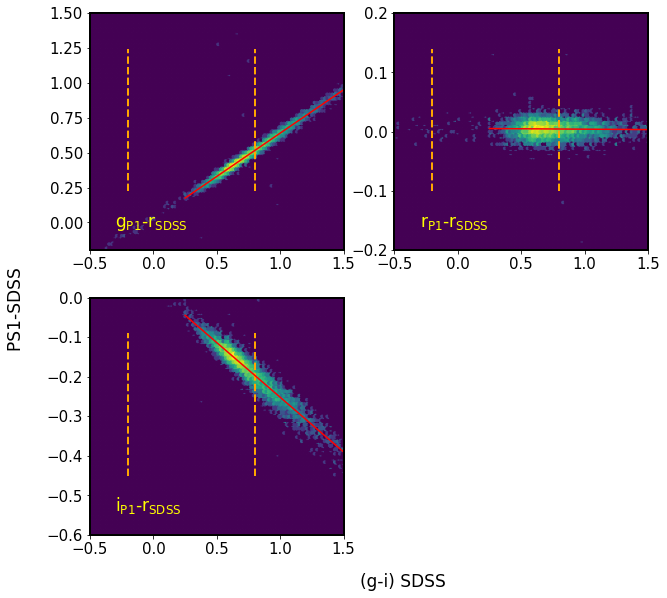

In [23]:
# Use as needed :  Fourth combination:  
# SDSS (g-i) vs PS1(grizy)  - SDSS(rrrrr ) : 
photometric_offset_sdss_ps1(data = sdss_ps1, sdsscolors = 'gi', targetbands = 'r',
                            originbands = 'gri',
                            cutoffmag = 19 , xlims = [-0.5,1.5] ,
                           correct_extinction = False ,ebv_sfd = None,
                            extinction = None, nrows = 2, ncols =2, 
                           )

In [51]:
# Find out if there are overlaps ...
ids = {}
for f in 'gri' : 
    fname = 'StarID_PS1'+f+'-SDSSr_ext-NO.txt'
    stars =  Table.read(fname, format='ascii')
    ids[f] = stars['starID']

In [55]:
gr_overlap = ids['g'][np.in1d(ids['g'], ids['r'])]
gri_overlap = gr_overlap[np.in1d(gr_overlap, ids['i'])]

In [59]:
gri_overlap.data

array([682664, 683559, 684502, ..., 678600, 677223, 681688])

In [66]:
# Lots of stars overlapping - very good! 
# Store these IDs,  and check with PTF g,R, and CRTS V,  
# if perhaps the same stars were used ... 
np.savetxt('PS1gri_SDSSr_starIDs_used.txt', gri_overlap.data, fmt='%d' )

### Derive other offsets (with extinction, to SDSS(g,i,z), from PS1(z,y), etc. ) -  NOT used 

 
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  30883  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6534  objects
(g_P1-g_SDSS)
 
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  26859  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6756  objects
(r_P1-r_SDSS)
 
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  21762  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  10504  objects
(i_P1-i_SDSS)
 
- Removing  2385  objects that do not have PS1 obs in that filter
- Removing  16491  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
- Removing  43  objects that have less than 4 obs in

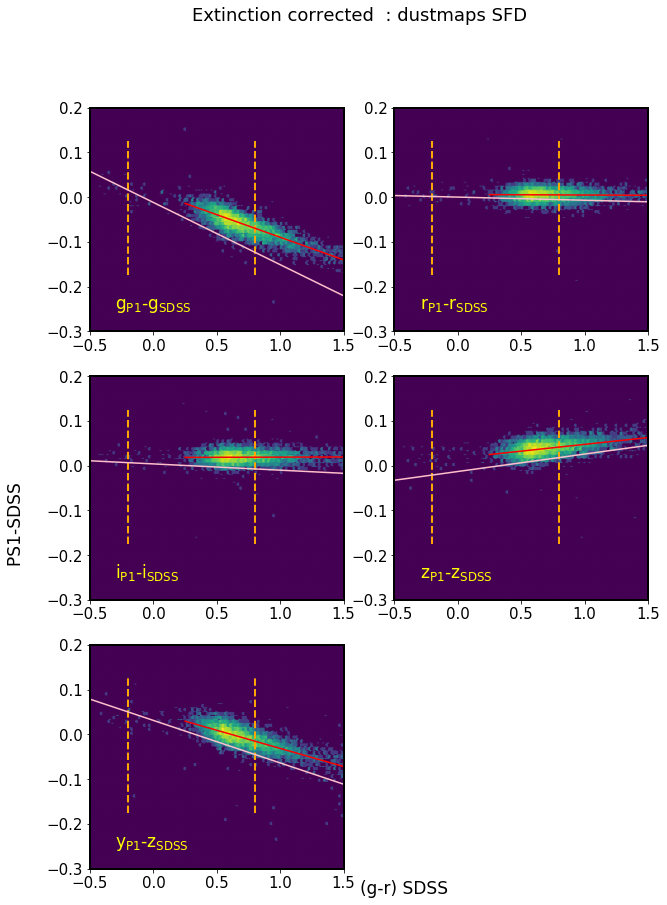

In [30]:
# Call the function to make four plots  :
    
# First :  (g-r) SDSS  vs PS1 (grizy) - SDSS(grizz) 
photometric_offset_sdss_ps1(sdss_ps1, xaxis = 'gr', yaxis = 'SDSSgrizz',
                            cutoffmag = 19,xlims = [-0.5,1.5] ,
                             correct_extinction = True,ebv_sfd = ebv_sfd,
                                extinction = 'SFD')




 
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  30883  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6534  objects
(g_P1-g_SDSS)
 
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  26859  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6756  objects
(r_P1-r_SDSS)
 
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  21762  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  10504  objects
(i_P1-i_SDSS)
 
- Removing  2385  objects that do not have PS1 obs in that filter
- Removing  16491  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
- Removing  43  objects that have less than 4 obs in

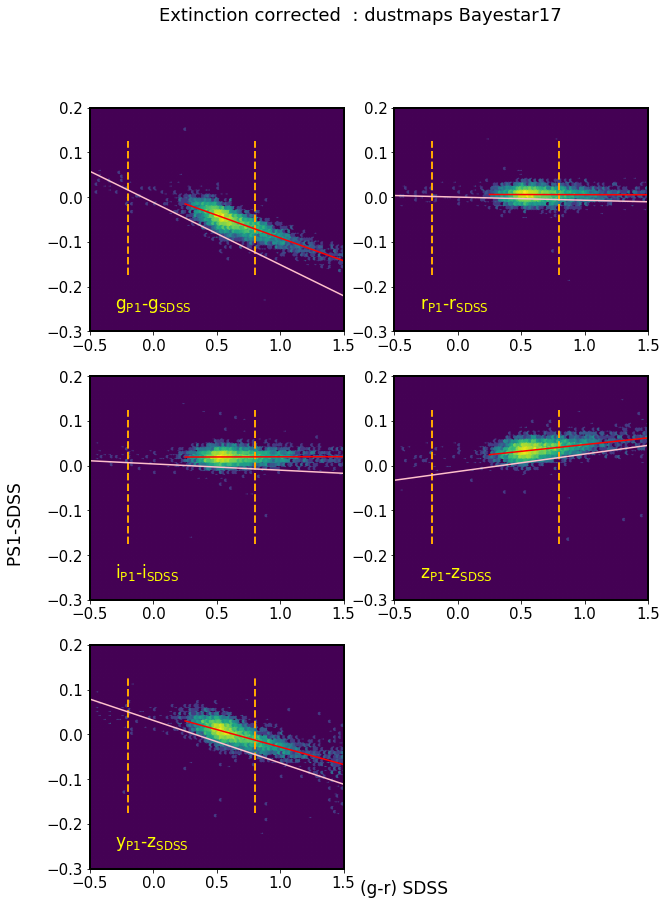

In [31]:
photometric_offset_sdss_ps1(data = sdss_ps1, xaxis = 'gr', yaxis = 'SDSSgrizz',
                            cutoffmag = 19,xlims = [-0.5,1.5] ,
                             correct_extinction = True,ebv_sfd = ebv,
                                extinction = 'Bayestar17')

In [23]:
Table(coeffs)

x,y,B_0,B_1
str10,str12,float64,float64
(g-r)_SDSS,g_P1-g_SDSS),0.0102888324691,-0.101660959198
(g-r)_SDSS,r_P1-r_SDSS),0.00597287771861,-0.00055420616223
(g-r)_SDSS,i_P1-i_SDSS),0.019198929568,0.000637386693086
(g-r)_SDSS,z_P1-z_SDSS),0.017104747251,0.0300067656247
(g-r)_SDSS,y_P1-z_SDSS),0.0494500308862,-0.0779055897849


 
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  30883  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6534  objects
 
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  26859  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6756  objects
 
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  21762  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  10504  objects
 
- Removing  2385  objects that do not have PS1 obs in that filter
- Removing  16491  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  14541  objects
 
- Removing  3288  objects that do not have PS1 obs in that filte

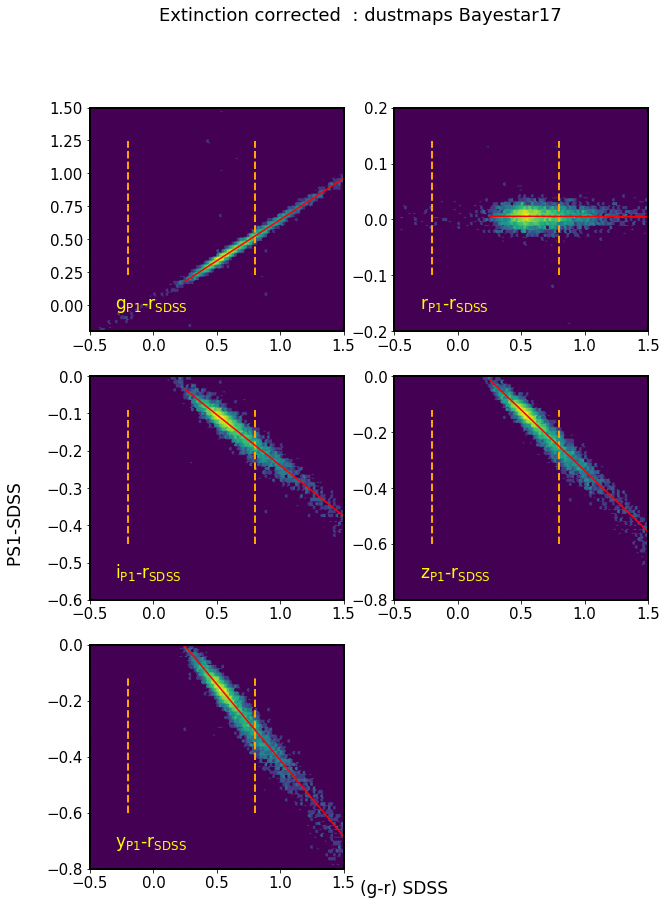

In [32]:
# Second :  (g-r) SDSS  vs PS1 (grizy) - SDSS(r) 
photometric_offset_sdss_ps1(data = sdss_ps1, xaxis = 'gr', yaxis = 'SDSSr',
                            cutoffmag = 19 ,xlims = [-0.5,1.5],
                            correct_extinction = True,ebv_sfd = ebv,
                            extinction = 'Bayestar17' )



In [ ]:
coeffs

 
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  30883  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6534  objects
 
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  26859  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6756  objects
 
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  21762  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  10504  objects
 
- Removing  2385  objects that do not have PS1 obs in that filter
- Removing  16491  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
- Removing  43  objects that have less than 4 obs in  this band
= Left with  14541  objects
 


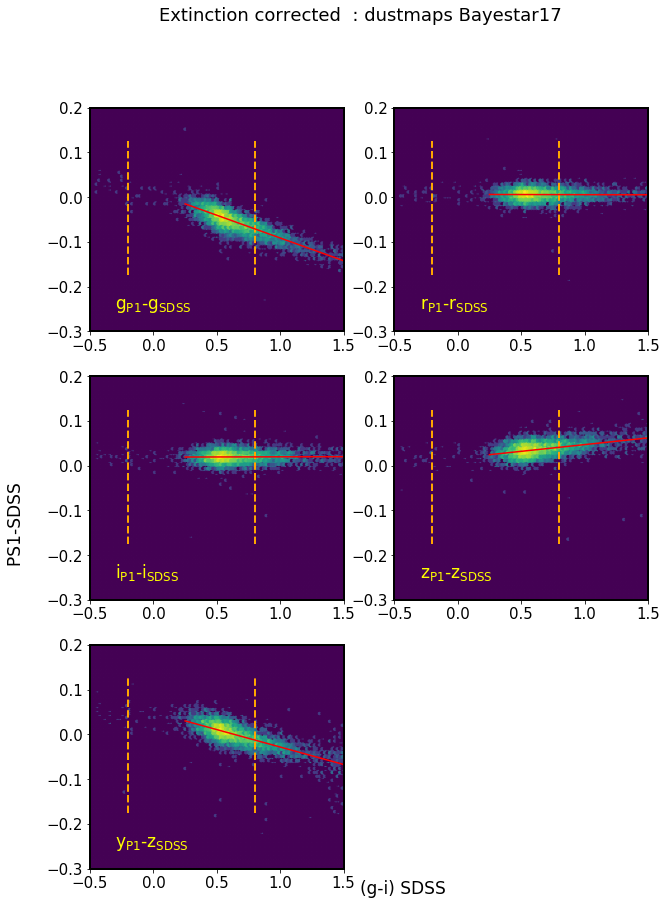

In [33]:

# Third:  (g-i) SDSS  vs PS1 (grizy) - SDSS(grizz) 
photometric_offset_sdss_ps1(data = sdss_ps1, xaxis = 'gi', yaxis = 'SDSSgrizz',
                            cutoffmag = 19 ,xlims = [-0.5,1.5] ,
                           correct_extinction = True,ebv_sfd = ebv,
                            extinction = 'Bayestar17' )




In [7]:
photometric_offset_sdss_ps1??

 
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  30883  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6534  objects
 
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  26859  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  6756  objects
 
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  21762  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  10504  objects
 
- Removing  2385  objects that do not have PS1 obs in that filter
- Removing  16491  objects that are fainter than  19
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  14541  objects
 
- Removing  3288  objects that do not have PS1 obs in that filte

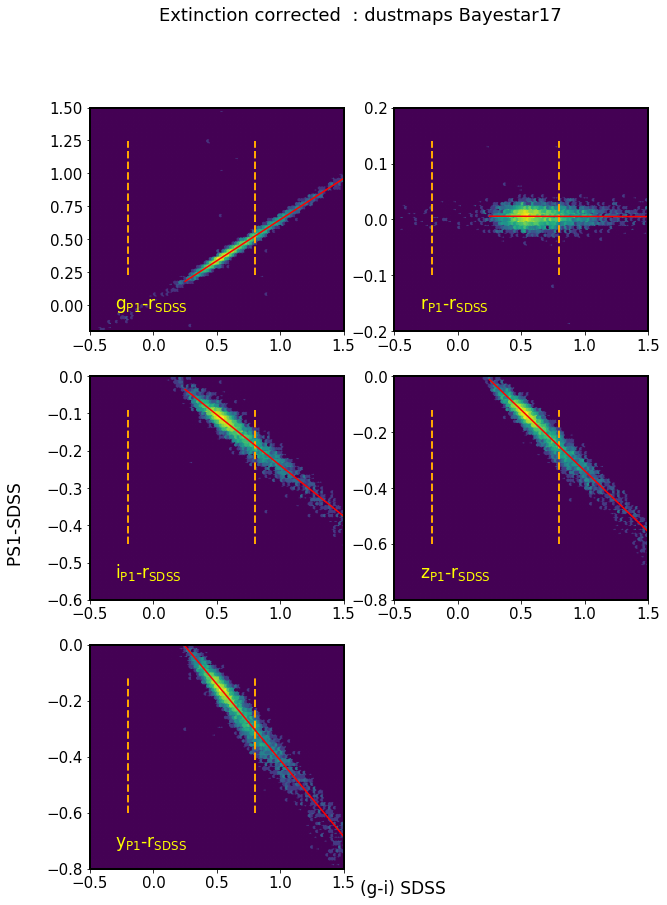

In [34]:
# Fourth :  (g-i) SDSS  vs PS1 (grizy) - SDSS(r) 
photometric_offset_sdss_ps1(data = sdss_ps1, xaxis = 'gi', yaxis = 'SDSSr',
                            cutoffmag = 19 , xlims = [-0.5,1.5] ,
                           correct_extinction = True,ebv_sfd = ebv,
                            extinction = 'Bayestar17' )

In [1]:
# Fourth :  (g-i) SDSS  vs PS1 (grizy) - SDSS(r) 
photometric_offset_sdss_ps1(data = sdss_ps1, xaxis = 'gi', yaxis = 'SDSSr',
                            cutoffmag = 20  , xlims = [-0.5,1.5] ,
                           correct_extinction = True,ebv_sfd = ebv,
                            extinction = 'Bayestar17' )

NameError: name 'photometric_offset_sdss_ps1' is not defined

### Apply each set of coefficients to an example light curve ... 

In [35]:
# Read the summary table with median SDSS, PS1, PTF, CRTS  band magnitude  per object ... 
summary = Table.read('summary_combined_lc_info.txt', format='ascii') 

In [45]:
# pick the LCs with best frequency ...
m1 = summary['SDSS_rN'] > np.percentile(summary['SDSS_rN'],90)
m2 = summary['PS1_rN'] > np.percentile(summary['PS1_rN'],90)


summary[m1*m2]

lcname,SDSS_uN,SDSS_medianuerr,SDSS_medianumag,SDSS_gN,SDSS_mediangerr,SDSS_mediangmag,SDSS_rN,SDSS_medianrerr,SDSS_medianrmag,SDSS_iN,SDSS_medianierr,SDSS_medianimag,SDSS_zN,SDSS_medianzerr,SDSS_medianzmag,PS1_gN,PS1_mediangerr,PS1_mediangmag,PS1_rN,PS1_medianrerr,PS1_medianrmag,PS1_iN,PS1_medianierr,PS1_medianimag,PS1_zN,PS1_medianzerr,PS1_medianzmag,PS1_yN,PS1_medianyerr,PS1_medianymag,PTF_1N,PTF_median1err,PTF_median1mag,PTF_2N,PTF_median2err,PTF_median2mag,CRTS_wN,CRTS_medianwerr,CRTS_medianwmag
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10579.txt,113.0,0.038,19.431,106.0,0.013,18.764,110.0,0.011,18.4855,113.0,0.013,18.391,113.0,0.03,18.18,11.0,0.0113328,18.319703,23.0,0.0123926,18.306998,10.0,0.01184665,18.226254,13.0,0.0212196,18.020512,12.0,0.04265585,18.0095825,0.0,nan,nan,3.0,0.056,18.441,212.0,0.08,18.465
3950223.txt,114.0,0.0475,19.7965,115.0,0.02,19.693,119.0,0.02,19.572,120.0,0.019,19.102,116.0,0.044,18.908,11.0,0.0223303,19.5247,31.0,0.0291703,19.484053,11.0,0.0188507,18.973858,9.0,0.0319839,18.763468,9.0,0.0713391,18.738611,0.0,nan,nan,20.0,0.056,19.2985,406.0,0.15,19.125
3959404.txt,107.0,0.024,18.785,114.0,0.013,18.6995,117.0,0.014,18.695,118.0,0.015,18.43,115.0,0.029,18.301,13.0,0.0214475,19.263859,25.0,0.021778,19.195145,13.0,0.0168069,18.882065,11.0,0.0343093,18.692126,11.0,0.0629425,18.776023,0.0,nan,nan,19.0,0.061,19.277,346.0,0.13,18.725
83896.txt,108.0,0.043,19.6245,110.0,0.015,19.328,113.0,0.016,19.167,108.0,0.017,18.983,109.0,0.047,18.737,10.0,0.02528915,19.6207215,42.0,0.02769935,19.4048745,13.0,0.0216675,19.142712,8.0,0.04195555,18.91486,8.0,0.07398735,18.83683,0.0,nan,nan,19.0,0.068,19.512,212.0,0.1,19.33
613850.txt,102.0,0.0895,20.652,114.0,0.021,19.8825,115.0,0.02,19.591,118.0,0.022,19.399,118.0,0.064,19.3135,10.0,0.0317606,19.8222295,24.0,0.026964,19.4927365,8.0,0.02823375,19.3221405,11.0,0.0483685,19.233681,12.0,0.10038145,19.20351,0.0,nan,nan,30.0,0.097,19.6885,245.0,0.21,19.43
4036521.txt,111.0,0.039,19.451,114.0,0.015,19.232,115.0,0.014,18.989,114.0,0.018,19.0915,115.0,0.054,19.145,13.0,0.017708,19.130069,29.0,0.0193425,19.069002,12.0,0.019799,19.0363865,13.0,0.04868,19.123127,16.0,0.0973494,18.9639025,61.0,0.05,18.964,0.0,nan,nan,76.0,0.1,19.07
3888561.txt,107.0,0.033,19.307,109.0,0.014,19.182,116.0,0.016,19.1165,114.0,0.018,18.986,112.0,0.04,18.725,13.0,0.0188482,19.125623,33.0,0.0270717,19.278055,13.0,0.0191485,18.954944,7.0,0.0287613,18.722035,10.0,0.07938385,18.8079575,0.0,nan,nan,18.0,0.0545,19.2545,191.0,0.1,18.93
3991959.txt,109.0,0.055,19.956,109.0,0.024,19.94,110.0,0.022,19.54,108.0,0.028,19.4615,109.0,0.089,19.56,15.0,0.0394334,20.0315,30.0,0.0283541,19.5184805,16.0,0.02960685,19.5110095,14.0,0.0599125,19.487636,11.0,0.120968,19.586063,2.0,0.0915,19.7145,0.0,nan,nan,116.0,0.19,19.2
3926895.txt,108.0,0.062,20.0705,114.0,0.022,19.8245,116.0,0.0235,19.756,117.0,0.028,19.666,115.0,0.087,19.455,17.0,0.0384568,20.064133,24.0,0.0437554,20.0718515,15.0,0.0339669,19.80605,10.0,0.0659332,19.612232,8.0,0.1514355,19.5655105,0.0,nan,nan,26.0,0.134,20.1685,98.0,0.24,19.545


(array([  107.,    65.,   126.,  2435.,  3220.,   239.,    48.,    85.,
           76.,    43.]),
 array([   2. ,   15.9,   29.8,   43.7,   57.6,   71.5,   85.4,   99.3,
         113.2,  127.1,  141. ]),
 <a list of 10 Patch objects>)

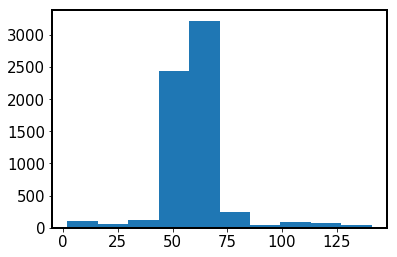

In [37]:
plt.hist(summary['SDSS_rN'])

(array([   32.,  1127.,  1854.,  1942.,   845.,   381.,   165.,    70.,
           20.,     8.]),
 array([  0. ,   4.6,   9.2,  13.8,  18.4,  23. ,  27.6,  32.2,  36.8,
         41.4,  46. ]),
 <a list of 10 Patch objects>)

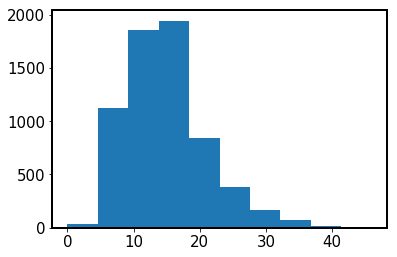

In [38]:
plt.hist(summary['PS1_rN'])

(array([  5.82000000e+03,   3.91000000e+02,   1.02000000e+02,
          2.10000000e+01,   7.00000000e+01,   3.80000000e+01,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   0.,   41.,   82.,  123.,  164.,  205.,  246.,  287.,  328.,
         369.,  410.]),
 <a list of 10 Patch objects>)

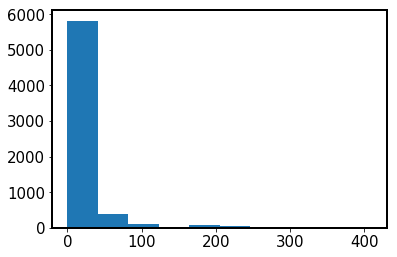

In [39]:
plt.hist(summary['PTF_2N'])

In [96]:
# Read in the offsets table 
# this one calculates 
# synthetic SDSS g band 
# from PS1 g band and mean g-r SDSS color 
offsets = Table.read('Offsets_PS1-SDSSgrizz_SDSSgr_ext-Bayestar17.txt',
                    format='ascii')
offsets[0]

x,y,B_0,B_1
str10,str12,float64,float64
(g-r)_SDSS,g_P1-g_SDSS),0.0102888324691,-0.101660959198


(array([  2.60000000e+01,   1.05000000e+02,   4.12000000e+02,
          9.77000000e+02,   1.15500000e+03,   1.03200000e+03,
          9.80000000e+02,   6.81000000e+02,   4.24000000e+02,
          1.98000000e+02,   1.42000000e+02,   8.60000000e+01,
          4.80000000e+01,   3.40000000e+01,   2.10000000e+01,
          1.80000000e+01,   1.40000000e+01,   1.50000000e+01,
          1.10000000e+01,   1.00000000e+01,   6.00000000e+00,
          8.00000000e+00,   1.10000000e+01,   4.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
        

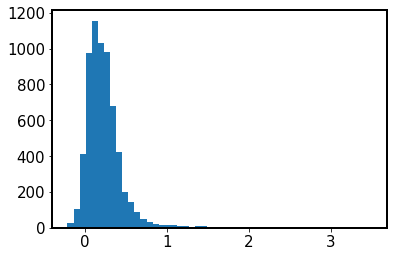

In [117]:

gr =  summary['SDSS_mediangmag']-summary['SDSS_medianrmag']
plt.hist(gr, bins=50)

SDSS g-r =  0.327 
SDSS g-i =  0.3105


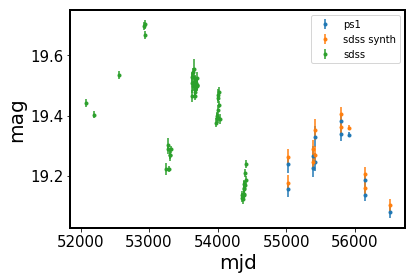

In [114]:
# the input combined  LCs
lcDir = '../data_products/SDSS-PTF-CRTS-PS1_/'
lcs = os.listdir(lcDir)
lcname = lcs[8] # '10579.txt'
lc = Table.read(lcDir+lcname, format='ascii')

# extract the color info about 
# this QSO from the survey 
row = summary[summary['lcname'] == lcname]

SDSS_gr = row['SDSS_mediangmag'][0] -row['SDSS_medianrmag'][0]
SDSS_gi = row['SDSS_mediangmag'][0] -row['SDSS_medianimag'][0]
print('SDSS g-r = ', SDSS_gr,
     '\nSDSS g-i = ', SDSS_gi)

i = 0 # iterate over all possible combinations of input / target filter 
# 0 corresponds to g filter 
# each light curve contains multiple bands ... 

offset = offsets[i]
SDSS_synth_band = offset['y'][5]
PS1_band = offset['y'][0]
B0 = offset['B_0']
B1 = offset['B_1']

# Make two new columns ..
lc['survey2'] = 'sdss'
lc['filter2'] = 'x'
lc['mag2'] = 0.0

# grab P1 data band by band ....
mask  = (lc['survey'] == ['ps1']) * (lc['filter'] == PS1_band)
P1 = lc['mag'][mask]

# declare new filter
lc['filter2'][mask] = SDSS_synth_band

# calculate synthetic magnitude using the g-r offsets 
SDSS_synth = P1 - B1 * SDSS_gr - B0
lc['mag2'][mask] = SDSS_synth


# plot the SDSS part, as well as the old PS1 and offset PS1 
m = (lc['filter'] == 'g' ) * (lc['survey'] == 'ps1')
plt.errorbar(lc['mjd'][m], lc['mag'][m], lc['magerr'][m], label='ps1',
            fmt=".", capsize=0)
plt.errorbar(lc['mjd'][m], lc['mag2'][m], lc['magerr'][m],
             label = 'sdss synth',fmt=".", capsize=0)
m = (lc['filter'] == 'g') * (lc['survey'] == 'sdss')
plt.errorbar(lc['mjd'][m], lc['mag'][m], lc['magerr'][m], label = 'sdss',
             fmt=".", capsize=0)
plt.legend()
plt.xlabel('mjd')
plt.ylabel('mag')
plt.savefig('lc_'+lcname[:-4] + '_sdss_ps1.png', bbox_inches='tight' )



In [106]:
lc

mag,magerr,mjd,filter,survey,survey2,filter2,mag2
float64,float64,float64,str1,str4,str4,str1,float64
20.139,0.058,51081.423478,u,sdss,sdss,x,0.0
20.296,0.055,51875.238387,u,sdss,sdss,x,0.0
20.275,0.055,52171.470809,u,sdss,sdss,x,0.0
20.212,0.051,52225.31926,u,sdss,sdss,x,0.0
20.4,0.06,52288.153684,u,sdss,sdss,x,0.0
20.35,0.071,52551.426968,u,sdss,sdss,x,0.0
20.368,0.059,52558.45984,u,sdss,sdss,x,0.0
20.332,0.054,52578.33145,u,sdss,sdss,x,0.0
20.213,0.053,52585.294431,u,sdss,sdss,x,0.0
